In [1]:
# configure udtk as parent folder
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from udtk import clustering, viz
import geopandas as gpd
from matplotlib.colors import ListedColormap
%matplotlib inline

/home/federico/anaconda3/envs/udtk/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/federico/anaconda3/envs/udtk/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
df = gpd.read_file('../carto/h3_aggregated_8.geojson')
df.head()

,h3_res_8,RetailArea,NumBldgs,geometry
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854..."
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801..."
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793..."
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795..."
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806..."


In [4]:
w = clustering.read_w_from_pickle('../data/w.pickle')

In [5]:
gdf = clustering.get_lisa(df, 'RetailArea', w)

('WARNING: ', '882a1072b9fffff', ' is an island (no neighbors)')


In [6]:
gdf

,h3_res_8,RetailArea,NumBldgs,geometry,lisa_cluster
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854...",Non-significant
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801...",Non-significant
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793...",Non-significant
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795...",Non-significant
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806...",Non-significant
...,...,...,...,...,...
108,882a1072cbfffff,2239.665154,1195,"POLYGON ((-73.98904 40.72516, -73.99541 40.724...",Non-significant
109,882a1072cdfffff,1188.193370,1448,"POLYGON ((-74.00227 40.73538, -74.00865 40.734...",Non-significant
110,882a1072d5fffff,6036.421687,107,"POLYGON ((-73.99493 40.71179, -74.00130 40.710...",Non-significant
111,882a1072d9fffff,1391.133333,29,"POLYGON ((-73.97580 40.71495, -73.98218 40.713...",Non-significant


In [7]:
from sklearn.cluster import DBSCAN

In [8]:
gdf.lisa_cluster.unique()

array(['Non-significant', 'LL', 'LH', 'HH', 'HL'], dtype=object)

In [9]:
gdf.head()

,h3_res_8,RetailArea,NumBldgs,geometry,lisa_cluster
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854...",Non-significant
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801...",Non-significant
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793...",Non-significant
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795...",Non-significant
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806...",Non-significant


In [20]:
def get_dbscan(gdf, quadrant, distance, nbours):
    '''
    This function returns the DBSCAN computed cluster label for high-high & low-low 
    quadrants.
    ...
    gdf(gdf): geodataframe with a 'lisa_cluster' Series label that indicates the quadrant of each grid.
    quadrant(str): name of the lisa quadrant (HH or LL).
    distance(float): the amount of kms per radian. Ej:0.5 represents a radius of 500mts.
    nbours(int): the amount of neighbours to be computed in min_samples parameter.
    '''

    # high-high or low-low quadrants
    quadrants = gdf.copy().loc[(gdf['lisa_cluster'] == quadrant)]
    # gdf coordinates
    list_q = list(quadrants.centroid.map(lambda g: [g.x, g.y]))
    
    kms_per_radian = 6371.0088
    eps_val = distance / kms_per_radian
    
    clustering_quadrant = DBSCAN(eps=eps_val, min_samples=nbours).fit(list_q)
    
    labels = clustering_quadrant.labels_
    
    quadrants['k'] = labels
    
    return quadrants

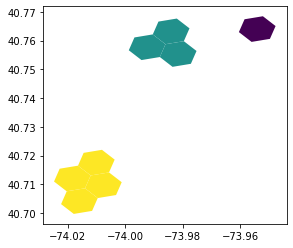

In [22]:
get_dbscan(gdf,'HH',100,3).plot(column='k');

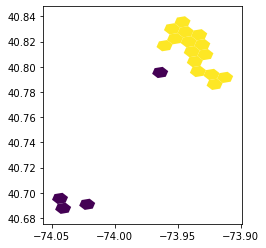

In [32]:
get_dbscan(gdf,'LL',100,3).plot(column='k');

In [33]:
hh = get_dbscan(gdf,'HH',100,3)

In [40]:
ll = get_dbscan(gdf,'LL',100,3)

In [56]:
hh['NumBldgs'].sort_values(ascending=True)

99      42
96     147
71     355
97     358
77     473
106    590
76     647
94     854
Name: NumBldgs, dtype: int64

In [59]:
hh_values = hh['NumBldgs'].sort_values(ascending=True)

In [62]:
hh_order = ['hh_'+str(i) for i in range(len(hh_values))]

In [67]:
hh['NumBldgs'].map(dict(zip(hh_values,hh_order)))

71     hh_2
76     hh_6
77     hh_4
94     hh_7
96     hh_1
97     hh_3
99     hh_0
106    hh_5
Name: NumBldgs, dtype: object

In [69]:
def get_dbscan(gdf, indicator,distance, nbours):
    '''
    This function returns the DBSCAN computed cluster label for high-high & low-low 
    quadrants.
    ...
    gdf(gdf): geodataframe with a 'lisa_cluster' Series label that indicates the quadrant of each grid.
    indicator (str): name of the indicator clustering.
    distance(float): the amount of kms per radian. Ej:0.5 represents a radius of 500mts.
    nbours(int): the amount of neighbours to be computed in min_samples parameter.
    '''

    # dbscan
    kms_per_radian = 6371.0088
    eps_val = distance / kms_per_radian
    
    # high-high 
    hh = gdf.copy().loc[(gdf['lisa_cluster'] == 'HH')]
    hh_coord = list(hh.centroid.map(lambda g: [g.x, g.y]))
    clustering_hh = DBSCAN(eps=eps_val, min_samples=nbours).fit(hh_coord)
    hh['k'] = clustering_hh.labels_
    hh_values = hh[indicator].sort_values(ascending=True)
    hh_order = ['hh_'+str(i) for i in range(len(hh_values))]
    hh['k_order'] = hh[indicator].map(dict(zip(hh_values,hh_order)))
    
    # low-low
    ll = gdf.copy().loc[(gdf['lisa_cluster'] == 'LL')]
    ll_coord = list(hh.centroid.map(lambda g: [g.x, g.y]))
    clustering_ll = DBSCAN(eps=eps_val, min_samples=nbours).fit(ll_coord)
    ll['k'] = clustering_ll.labels_
    ll_values = ll[indicator].sort_values(ascending=True)
    ll_order = ['ll_'+str(i) for i in range(len(ll_values))]
    ll['k_order'] = ll[indicator].map(dict(zip(ll_values,ll_order)))

    quadrants = hh.append(ll)
    
    return quadrants

In [70]:
get_dbscan(gdf,'NumBldgs',100,3)

ValueError: Length of values does not match length of index

In [ ]:
#from udtk.clustering import get_dbscan

In [ ]:
clustering.get_dbscan(gdf)

In [ ]:
viz.plot_lisa(gdf)

In [ ]:
from pysal.explore.esda.moran import Moran_Local


In [ ]:
Moran_Local?